This notebook is used to train the model from the extracted features from the Extrinsic, Intrinsic and Task feature dataframes. From the feature extraction there is an extrinsic csv file and an "intrinsic" csv file consisting of both the intrinsic and task data features.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


The two csv files are loaded into the script. For some reason the "id" column name from the intrinsic dataframe  got removed so the initial column is renamed to "id" from "unnamed". Then the dataframes are merged to a single combined feature dataframe

In [3]:
feature_df_i = pd.read_csv(r"C:\Users\kaspe\Documents\GitHub\AAU-IoT-Solution-AI-REDGIO\CodeForProject\tsfresh_efficient_features.csv")

feature_df_i = feature_df_i.rename(columns={'Unnamed: 0': 'id'})

feature_df_e = pd.read_csv(r"C:\Users\kaspe\Documents\GitHub\AAU-IoT-Solution-AI-REDGIO\audio_features_clean.csv")

feature_df = pd.merge(feature_df_i, feature_df_e, on='id')

feature_df = feature_df.rename(columns={'Unnamed: 0': 'id'})

print(feature_df)

                  id  TCP_rz (rad)__variance_larger_than_standard_deviation  \
0     id030520234000                                                0.0       
1     id030520234001                                                0.0       
2     id030520234002                                                0.0       
3     id030520234003                                                0.0       
4     id030520234004                                                0.0       
...              ...                                                ...       
1336  id280420233082                                                0.0       
1337  id280420233083                                                0.0       
1338  id280420233084                                                0.0       
1339  id280420233085                                                0.0       
1340  id280420233086                                                0.0       

      TCP_rz (rad)__has_duplicate_max  TCP_rz (rad)

Now the list of labels need to be made. The dataset from the previous project contains a list of labels for all data entries with extrinsinc, intrinsinc and task data entries listed in continuation of each other. Initially the column "File name" is renamed so that it matches the "id" we have used in this script. Since every data point will have 3 separate entries with the same label (eg. e2010202, i2010202 and t2010202), it is only needed to have 1 of those three for every data entry, as we only need 1 label pr. data point. Therefore we filter the lister for all entries starting with "e". We replace the e with "id" so that it matches the name given in the feature dataframes. We create an encoder that can map the labels from categorical (N, NS etc.) to numerical values (0,1,2,3,4). And then lastly the labels are merged onto the feature dataframe, ensuring to only add the entries with valid features available.

In [4]:
# Rename columns in the label file
labels = pd.read_csv(r"C:\Users\kaspe\Documents\GitHub\AAU-IoT-Solution-AI-REDGIO\data_ozren\Labels_names.csv")
labels = labels.rename(columns={'File Name': 'id'})

# Filter labels to include only entries where id starts with "e"
labels = labels[labels['id'].str.startswith('e')]

# Replace "e" prefix with "id" in the filtered labels DataFrame
labels['id'] = labels['id'].str.replace('e', 'id', regex=False)

# Create a LabelEncoder instance
encoder = LabelEncoder()

# Fit the encoder and transform the labels
labels['Label'] = encoder.fit_transform(labels['Label'])

# Print original labels and their encoded values
for original, encoded in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f'Original: {original}, Encoded: {encoded}')

# Merge features and labels
data = pd.merge(feature_df, labels, on='id', how='inner')  # Ensure inner merge to match only relevant rows

# Print the merged DataFrame
print(labels)

print(data.info)


Original: N, Encoded: 0
Original: NS, Encoded: 1
Original: OT, Encoded: 2
Original: P, Encoded: 3
Original: UT, Encoded: 4
                  id  Label
0     id030520235006      0
1     id030520235007      0
2     id030520236000      0
3     id030520236002      0
4     id030520236003      0
...              ...    ...
1336  id280420232069      4
1337  id280420232080      4
1338  id280420233013      4
1339  id280420233045      4
1340  id280420233069      4

[1341 rows x 2 columns]
<bound method DataFrame.info of                   id  TCP_rz (rad)__variance_larger_than_standard_deviation  \
0     id030520234000                                                0.0       
1     id030520234001                                                0.0       
2     id030520234002                                                0.0       
3     id030520234003                                                0.0       
4     id030520234004                                                0.0       
...       

A check for NaN values is made. They all came out false meaning NaN has already been fully filtered out.

In [5]:
nan_columns = data.isna().any()
nan_cols_list = data.columns[data.isna().any()].tolist()

print(nan_columns)
print(nan_cols_list)

id                                                       False
TCP_rz (rad)__variance_larger_than_standard_deviation    False
TCP_rz (rad)__has_duplicate_max                          False
TCP_rz (rad)__has_duplicate_min                          False
TCP_rz (rad)__has_duplicate                              False
                                                         ...  
mfcc_37                                                  False
mfcc_38                                                  False
mfcc_39                                                  False
mfcc_40                                                  False
Label                                                    False
Length: 9315, dtype: bool
[]


Now that the entries are aligned in the dataframe with their corresponding label, it is not necesary to have an identifier for each entry anymore, therefore we drop that column, and define our feature matrix and the label vector.

In [6]:
# Drop filename column (we don't need it for the model)
data = data.drop(columns='id')

# Separate features and labels
X = data.drop(columns='Label')
y = data['Label']

Now the features are scaled using the standardscaler. The formula used for hte scaler can be seen in the project report. The scaler standardizes the features by removing the mean and scaling to unit variance.

In [7]:
#Scaling features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Assume that data contains only features and no labels.
scaled_data = scaler.fit_transform(X)

# Convert the numpy array back into pandas dataframe
scaled_data = pd.DataFrame(scaled_data, columns=X.columns)

And the data can then be split into a test and training set. Note that X is the feature matrices and y is the label vectors.

In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.4, random_state=42)

Svm train

In [9]:
# Create a SVM model with a radial basis function (RBF) kernel
from sklearn import svm
#svm_model = SVC(kernel='rbf')
svm_model = svm.SVC(kernel='rbf', probability=True)
# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_s = svm_model.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred_s))
print('Accuracy:', accuracy_score(y_test, y_pred_s))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       165
           1       0.98      0.98      0.98        66
           2       0.94      0.94      0.94       138
           3       0.88      1.00      0.94        59
           4       0.93      0.96      0.95       109

    accuracy                           0.95       537
   macro avg       0.95      0.96      0.95       537
weighted avg       0.95      0.95      0.95       537

Accuracy: 0.9515828677839852


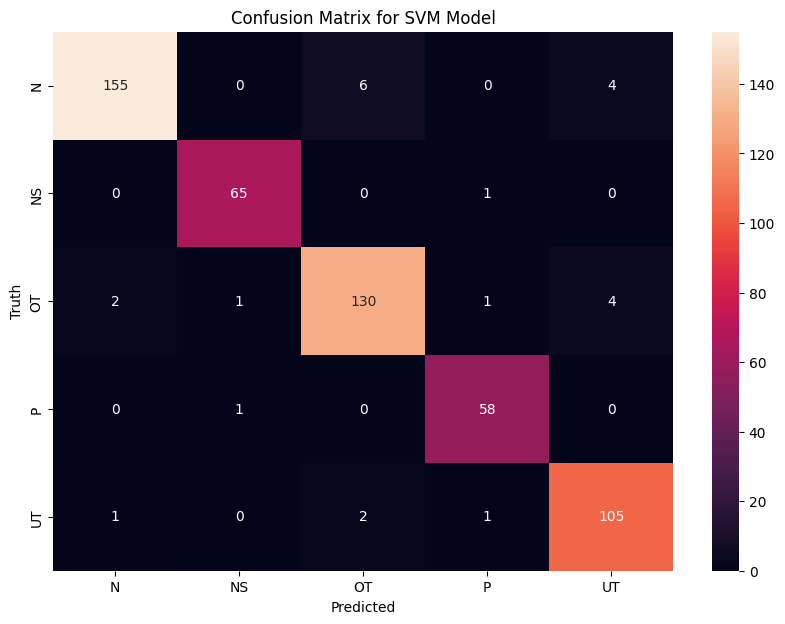

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred_s = svm_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_s)

# Create a heatmap for visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for SVM Model')

# Show the plot
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

# Predictions on the test data
y_pred_s = svm_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_s)

# Precision (macro-average)
precision = precision_score(y_test, y_pred_s, average='macro')

# Recall (macro-average)
recall = recall_score(y_test, y_pred_s, average='macro')

# F2-score (macro-average)
f2_score = fbeta_score(y_test, y_pred_s, beta=2, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2-score: {f2_score:.4f}")


Accuracy: 0.9553
Precision: 0.9546
Recall: 0.9625
F2-score: 0.9608


Train KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Creating the KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Training the KNN classifier on the training data
knn.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_k = knn.predict(X_test)

# Evaluating the KNN classifier's performance
print(classification_report(y_test, y_pred_k))
# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred_k))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       165
           1       0.89      0.97      0.93        66
           2       0.93      0.96      0.94       138
           3       0.93      0.88      0.90        59
           4       0.94      0.94      0.94       109

    accuracy                           0.94       537
   macro avg       0.93      0.94      0.93       537
weighted avg       0.94      0.94      0.94       537

Accuracy: 0.9404096834264432


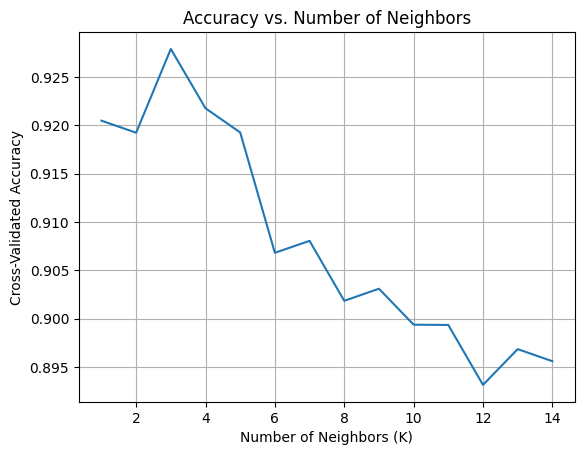

Best parameters:  {'n_neighbors': 3}
Best cross-validation score:  0.9279012345679012


In [32]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Define the parameter values to be searched
k_range = list(range(1, 15))

# Create a parameter grid: map the parameter names to the values to be searched
param_grid = dict(n_neighbors=k_range)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the grid with data
grid.fit(X_train, y_train)

# Extract mean cross-validation scores for each K value
mean_scores = grid.cv_results_['mean_test_score']

# Plot the scores
plt.figure()
plt.plot(k_range, mean_scores)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.show()

# Print the details
print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: ", grid.best_score_)

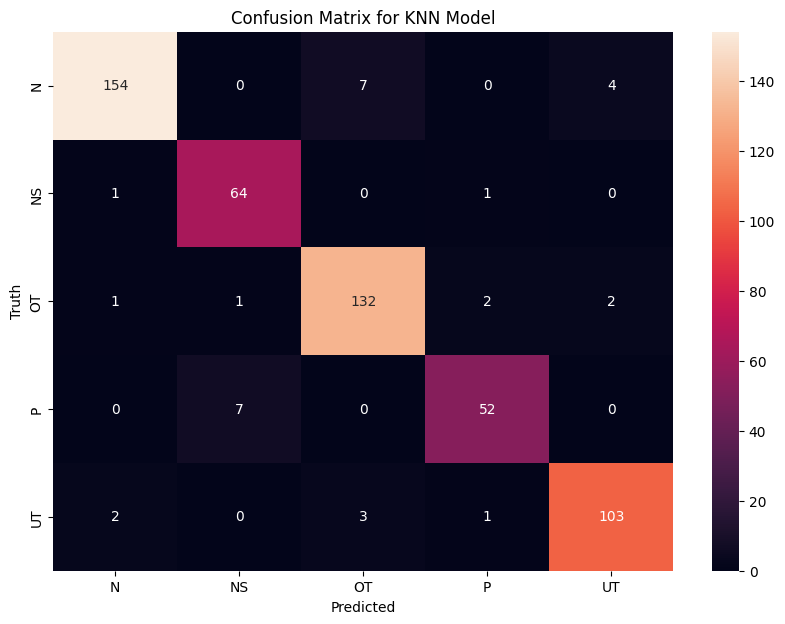

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred_k = knn.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_k)

# Create a heatmap for visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for KNN Model')

# Show the plot
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

# Predictions on the test data
y_pred_k = knn.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_k)

# Precision (macro-average)
precision = precision_score(y_test, y_pred_k, average='macro')

# Recall (macro-average)
recall = recall_score(y_test, y_pred_k, average='macro')

# F2-score (macro-average)
f2_score = fbeta_score(y_test, y_pred_k, beta=2, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2-score: {f2_score:.4f}")


Accuracy: 0.9404
Precision: 0.9333
Recall: 0.9372
F2-score: 0.9360


Random forrest decision

In [16]:
# Define the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Split data into training and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the model
model.fit(X_train_r, y_train_r)

# Make predictions on the test set
y_pred_r = model.predict(X_test_r)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_r, y_pred_r))


# Evaluate the model's performance
print(classification_report(y_test_r, y_pred_r))

Accuracy: 0.9702048417132216
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       165
           1       0.99      1.00      0.99        66
           2       0.98      0.94      0.96       138
           3       0.97      1.00      0.98        59
           4       0.93      0.97      0.95       109

    accuracy                           0.97       537
   macro avg       0.97      0.98      0.97       537
weighted avg       0.97      0.97      0.97       537



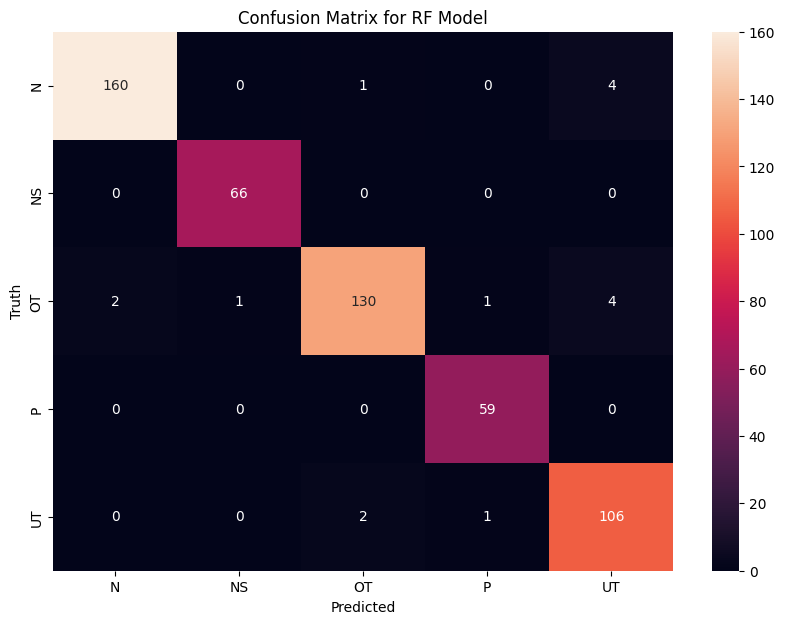

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred_r = model.predict(X_test_r)

# Compute the confusion matrix
cm = confusion_matrix(y_test_r, y_pred_r)

# Create a heatmap for visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for RF Model')

# Show the plot
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the number of estimators
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250]  # Define the range of values to test
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(X_train_r, y_train_r)

# Output the best parameter and its corresponding score
best_n_estimators = grid_search.best_params_['n_estimators']
best_score = grid_search.best_score_

print(f"The optimal number of estimators is: {best_n_estimators}")
print(f"Cross-validated accuracy for the optimal number of estimators: {best_score:.4f}")


The optimal number of estimators is: 100
Cross-validated accuracy for the optimal number of estimators: 0.9639


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

# Predictions on the test data
y_pred_r = model.predict(X_test_r)

# Accuracy
accuracy = accuracy_score(y_test_r, y_pred_r)

# Precision (macro-average)
precision = precision_score(y_test_r, y_pred_r, average='macro')

# Recall (macro-average)
recall = recall_score(y_test_r, y_pred_r, average='macro')

# F2-score (macro-average)
f2_score = fbeta_score(y_test_r, y_pred_r, beta=2, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2-score: {f2_score:.4f}")


Accuracy: 0.9702
Precision: 0.9694
Recall: 0.9768
F2-score: 0.9752


C:\Users\kaspe\AppData\Local\Temp\ipykernel_32920\2564811021.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forest_importances[sorted_idx[:N]].plot(kind='barh', ax=ax)


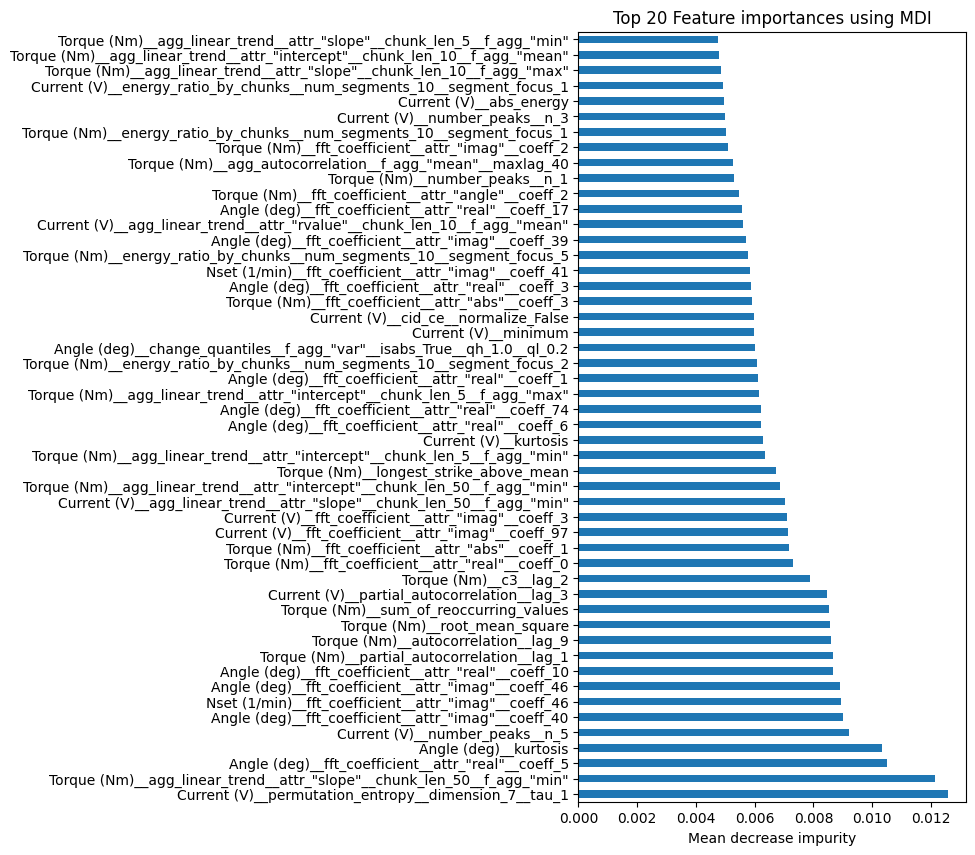

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assume rf_model is your trained RandomForestClassifier
importances = model.feature_importances_

# Get the names of the features from your dataframe
feature_names = X.columns

# Create arrays from feature importance and feature names
forest_importances = pd.Series(importances, index=feature_names)

# Define the number of most important features to plot
N = 50

# Sort the feature importances in decreasing order
sorted_idx = np.argsort(forest_importances)[::-1]

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(5, 10))

# Create a bar plot for the top N features
forest_importances[sorted_idx[:N]].plot(kind='barh', ax=ax)

# Set the labels
ax.set_title("Top 20 Feature importances using MDI")
ax.set_xlabel("Mean decrease impurity")

# Show the plot
plt.show()

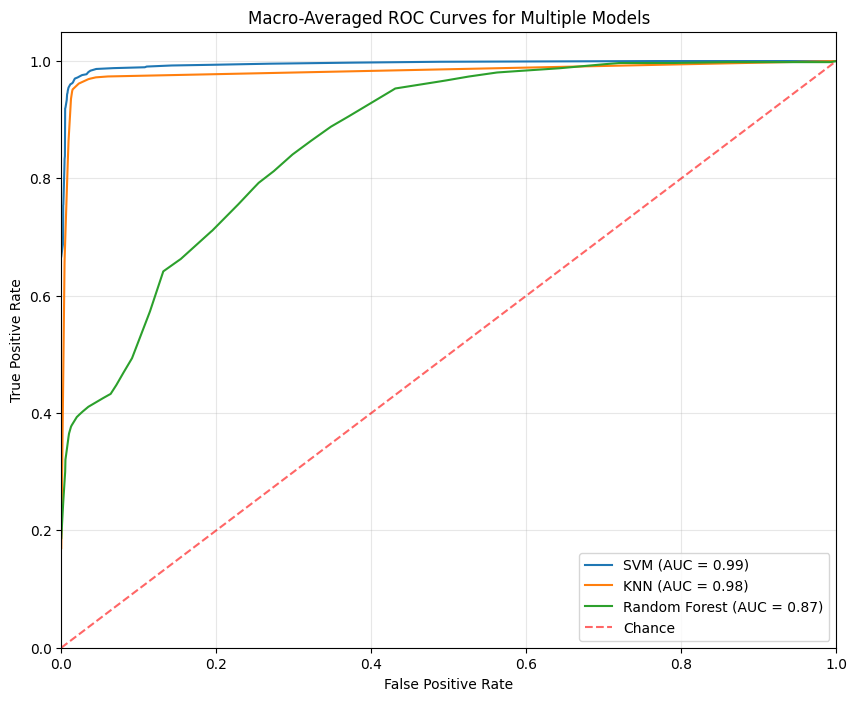

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate macro-average ROC curve
def calculate_macro_roc(model, X_test, y_test, classes):
    # Binarize the labels for multiclass ROC computation
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)
    
    # Predict probabilities
    y_score = model.predict_proba(X_test)
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr["macro"], tpr["macro"], roc_auc["macro"]

# List of models to evaluate
models = {
    "SVM": svm_model,
    "KNN": knn,
    "Random Forest": model
}

# Classes in the dataset (assume they are 0, 1, 2, ..., n_classes-1)
classes = sorted(set(y_test))

# Plot the macro-average ROC curves for all models
plt.figure(figsize=(10, 8))
for name, model in models.items():
    fpr, tpr, roc_auc = calculate_macro_roc(model, X_test, y_test, classes)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random chance)
plt.plot([0, 1], [0, 1], 'r--', label='Chance', alpha=0.6)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curves for Multiple Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
